## Preprocessing

#### paste following lines into anaconda prompt (as admin) and press enter: 
#### conda install -c huggingface -c conda-forge datasets
#### conda install -c anaconda gensim


In [1]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re, string, nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec, FastText
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from scipy import sparse


# Train test split and class distribution

[nltk_data] Downloading package wordnet to /Users/zeynep/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zeynep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/zeynep/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zeynep/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Using custom data configuration default
Reusing dataset ag_news (/Users/zeynep/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

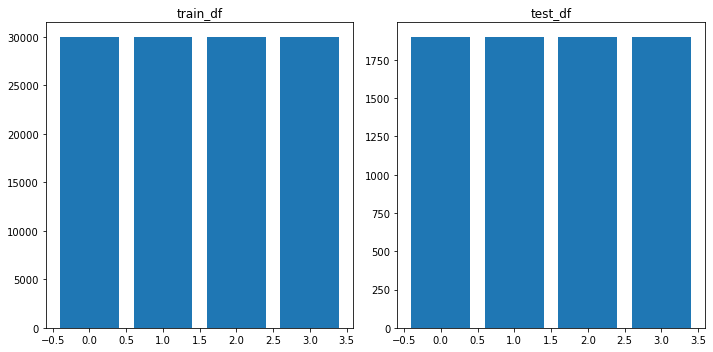

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# train-test split
dataset = load_dataset("ag_news")
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])
del dataset

def class_distribution():
    
    # checking class distribution
    plt.figure(figsize=(10,5))

    ## train data
    plt.subplot(1,2,1)
    train_df_target = train_df['label']
    class_dist = pd.Series(train_df_target).value_counts()
    plt.title('train_df')
    plt.bar(class_dist.index, class_dist)
    plt.tight_layout()

    ## test data
    plt.subplot(1,2,2)
    test_df_target = test_df['label']
    class_dist = pd.Series(test_df_target).value_counts()
    plt.title('test_df')
    plt.bar(class_dist.index, class_dist)
    plt.tight_layout()

    plt.show()

def balanced_fractionize(df, frac):
    
    frac_df = df.sample(frac=frac, random_state=42)
    frac_data, frac_target = frac_df['text'].values.reshape(-1, 1), frac_df['label'].values.reshape(-1, 1)
    
    sampler = RandomUnderSampler()
    bal_frac_data, bal_frac_target = sampler.fit_resample(frac_data, frac_target)
    
    class_dist = pd.Series(bal_frac_target).value_counts()
    plt.bar(class_dist.index, class_dist)
    plt.ylabel("Frequency")
    plt.show()
    
    return pd.DataFrame(bal_frac_data, columns = ['text']), pd.DataFrame(bal_frac_target, columns = ['label'])

class_distribution()

In [3]:
#initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
wnl = WordNetLemmatizer()


def preprocessing(text):
    
    # convert to lowercase and remove spaces at beginning and ending
    text = text.lower().strip()
    
    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    # remove html code
    text= re.sub('<.*?>', '', text) 
    
    # remove special characters
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    # remove digits
    text = re.sub(r'\d',' ',text)
    
    # replace multiple whitespaces with one
    text = re.sub('\s+', ' ', text)
    
    # stop word removal
    clean_text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # tonkenize & lemmatize
    word_pos_tags = nltk.pos_tag(word_tokenize(clean_text)) # -> list of tuples (word, pos_tag) [('computer', 'NN'), ('word', 'tag')]
    lem_text = ' '.join([wnl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for tag in word_pos_tags])

    return lem_text

 
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        # default pos
        return wordnet.NOUN
    


In [4]:
# execute preprocessing for training set
train_df['text'] = train_df['text'].apply(lambda x: preprocessing(x))
train_df.to_csv('training_data.csv', sep=';', encoding='utf-8', index=False)
train_df.head()

,text,label
0,wall st bear claw back black reuters reuters s...,2
1,carlyle look toward commercial aerospace reute...,2
2,oil economy cloud stock outlook reuters reuter...,2
3,iraq halt oil export main southern pipeline re...,2
4,oil price soar time record pose new menace u e...,2


## Vectorization

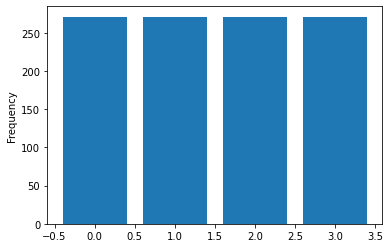

In [29]:
# read in preprocessed training data if necessary
train_df = pd.read_csv('preprocessed_training_data.csv', sep=';', encoding='utf-8')

#fractionize and undersample data
train_data, train_target = balanced_fractionize(train_df, 0.01)

#Tokenize
def get_train_tokens(df_data):
    return [word_tokenize(text) for text in df_data['text']]

### Count vectors and Tf-idf vectors

In [16]:
def get_tfid_vectors(df_data, param_comb={'analyzer': 'word'}):
    tfidf_vectorizer = TfidfVectorizer(**param_comb)
    return tfidf_vectorizer.fit_transform(df_data['text']).toarray()

def get_count_vectors(df_data, param_comb={'analyzer': 'word'}):
    count_vectorizer = CountVectorizer(**param_comb)
    return count_vectorizer.fit_transform(df_data['text']).toarray()

### Word2Vec SkipGram & CBOW

In [7]:
# returns mean w2v vector for list of specified words
def get_embedding(model, text):
    existing_words = [word for word in text if word in list(model.wv.index_to_key)]
    if existing_words:
        embedding = np.zeros((len(existing_words), model.vector_size), dtype=np.float32)
        for i, w in enumerate(existing_words):
                embedding[i] = model.wv[w]
        return np.mean(embedding, axis=0)
    else:
        return np.zeros(model.vector_size)

    
# need to specify parameters in param_comb in form of a dict  
def get_w2v_cbow_embeddings(tokens, param_comb):
    w2v_cbow = Word2Vec(tokens, **param_comb)
    # get mean vector for each article description for both models
    return np.array([get_embedding(w2v_cbow, text) for text in tokens])

# need to specify parameters in param_comb in form of a dict  
def get_w2v_skipg_embeddings(tokens, param_comb):
    w2v_skipg = Word2Vec(tokens, **param_comb, sg = 1)
    # get mean vector for each article description for both models
    return np.array([get_embedding(w2v_skipg, text) for text in tokens])

### fastText

In [8]:
# need to specify parameters in param_comb in form of a dict  
def get_fasttext_embeddings(tokens, param_comb):
    fasttext = FastText(**param_comb)
    fasttext.build_vocab(corpus_iterable=tokens)
    fasttext.train(corpus_iterable=tokens, total_examples=len(tokens), epochs=10)
    return np.array([get_embedding(fasttext, text) for text in tokens])

### GloVe

In [9]:
# write content into file
with open('corpus.txt', 'w') as f:
    for text in train_data['text'].tolist():
        f.write(text + '\n')
# train vectors with https://github.com/stanfordnlp/GloVe with standard parameters
#Example vectors uploaded to Git were trained with 0.2 percent of the data

In [10]:
def get_glove_document_vector(text, vocab, vectors, vector_size):
    existing_words = [word for word in text if word in vocab]
    if existing_words:
        embedding = np.zeros((len(existing_words), vector_size), dtype=np.float32)
        for i, w in enumerate(existing_words):
                embedding[i] = vectors[w]
        return np.mean(embedding, axis=0)
    else:
        return np.zeros(model.vector_size)
    

# needs tokens from same fraction of training data as the GloVe embeddings were trained with
def get_glove_embeddings(tokens):
    vocab = []
    vectors = {}
    with open('vocab.txt') as f:
        for ln in f:
            words = ln.split()
            vocab = vocab + words[:1]
    with open('vectors.txt') as f:
        for ln in f:
            word = ln.split()[0]
            vector = [float(number) for number in ln.split()[1:]]
            vectors[word] = vector
            
    return np.array([get_glove_document_vector(text, vocab, vectors, len(vector)) for text in tokens])

In [11]:
vectorizer_names = ["tfidf_vectors", "count_vectors", "w2v_cbow", "w2v_skipg", "fasttext", "GloVe"]

#returns vector-matrix with specified vectorizer on specified data
def get_vectorMatrix(vectorizer_name, df_data):
    for vectorizer_name in vectorizer_names:
        if vectorizer_name == "tfidf_vectors":
            return get_tfid_vectors(df_data)
        elif vectorizer_name == "count_vectors":
            return get_count_vectors(train_data)
        elif vectorizer_name == "w2v_cbow":
            train_tokens = get_train_tokens(train_data)
            return get_w2v_cbow_embeddings(train_tokens)
        elif vectorizer_name == "w2v_skipg":
            train_tokens = get_train_tokens(train_data)
            return get_w2v_skipg_embeddings(train_tokens)
        elif vectorizer_name == "fasttext":
            train_tokens = get_train_tokens(train_data)
            return get_fasttext_embeddings(train_tokens)
        elif vectorizer_name == "GloVe":
            train_tokens = get_train_tokens(train_data)
            return get_glove_embeddings(train_tokens)

## Classification

In [27]:

vectorizer_names = ["tfidf_vectors", "count_vectors", "w2v_cbow", "w2v_skipg", "fasttext", "GloVe"]

get_vectorMatrix("w2v_skipg", train_data)
        

<23644x27170 sparse matrix of type '<class 'numpy.float64'>'
	with 509918 stored elements in Compressed Sparse Row format>

### Hyperparameter Tuning

In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from numpy import mean
from numpy import std

# hyperparameter tuning
def param_search(vector_matrix, vector_matrix_name, estimator):
    
    estimator_name = estimator['name']
    parameters = estimator['parameters']
    estimator = estimator['estimator']
    
    # configure the cross-validation procedure
    cv_outer = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # enumerate splits
    outer_results = list()
    X = vector_matrix
    y = train_target['label']
    
    for train_ix, test_ix in cv_outer.split(X,y):
        
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
    
        # specify the nested cross validation
        nested_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

        # create the grid search instance
        search = GridSearchCV(estimator, parameters, scoring='accuracy', cv=nested_cv, n_jobs=-1, refit=True)
        
        # execute search
        result = search.fit(vector_matrix, train_target['label'])
        
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        
        # evaluate model on the hold out dataset
        predictions = best_model.predict(X_test)
        
        # evaluate the model
        acc = accuracy_score(y_test, predictions)
        
        # store the result
        outer_results.append(acc)
        
        # report progress
        print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    # summarize the estimated performance of the model
    accuracy_mean = mean(outer_results)
    
    #print the best parameter setting
    print("Classifier: {}".format(estimator_name))
    print("Vectorizer: {}".format(vector_matrix_name))
    print("Mean Accuracy: {}".format(accuracy_mean))
    print()
    
    return accuracy_mean, best_model

In [32]:
# tune for the best vectorizer-estimator combination
def hyper_tune():
    
    kNeighbors_parameters = {
        'n_neighbors': list(range(10,15))
    }
    
    decisionTree_parameters = {
        'criterion':['gini', 'entropy'], 
        'max_depth': [40,60,80,100],
        'min_samples_split' : list(range(20,30,2))
    }
    
    
    MultinomialNB_parameters = {
        'fit_prior': (True, False),
        'alpha': [0.0001,0.001,0.01,0.1]        

    }
    
    svc_parameters = {
        'C': [0.1, 1.0, 10.0],
        'gamma': ['auto', 'scale'],
        'kernel': ['rbf', 'poly', 'sigmoid'],
        'degree' : [3,4,5,6]
    }
    
    mlpClassifier_parameters = {
        'learning_rate': ['constant', 'adaptive'],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'hidden_layer_sizes':[120,130,140]
    }
    
    rfc_parameters = {
        'max_depth': list(range(40,90,10)), 
        'max_features': ['sqrt'],
        'n_estimators':list(range(130,140,2))
    } 
    

    wordEmbedding_std_parameters = {
        'window': 5,
        'vector_size': 200,
        'min_count': 5
    }

    
    
    # ------ VECTORIZERS ------
    train_tokens = get_train_tokens(train_data)
    
    #TODO: add the other matrices, when done
    vectorizer_values = [
        get_tfid_vectors(train_data), get_count_vectors(train_data),
        get_w2v_cbow_embeddings(train_tokens, wordEmbedding_std_parameters), get_w2v_skipg_embeddings(train_tokens, wordEmbedding_std_parameters),
        get_fasttext_embeddings(train_tokens, wordEmbedding_std_parameters),get_glove_embeddings(train_tokens)
    ]
    
    vectorizer_names = ["tfidf_vectors", "count_vectors", "w2v_cbow", "w2v_skipg", "fasttext","GloVe"]
    vectorizers = dict(zip(vectorizer_names, vectorizer_values))
    
    del train_tokens
    
    # ------ ESTIMATORS ------
    #TODO: add more estimators
    estimators = {
        'KNeighborsClassifier': { 'name': 'KNeighborsClassifier', 'estimator': KNeighborsClassifier(), 'parameters': kNeighbors_parameters },
        'DecisionTreeClassifier': { 'name': 'DecisionTreeClassifier', 'estimator': DecisionTreeClassifier(), 'parameters': decisionTree_parameters },
        #'MultinomialNB': { 'name': 'MultinomialNB', 'estimator': MultinomialNB(), 'parameters': MultinomialNB_parameters },
        'SVC': { 'name': 'SVC', 'estimator': SVC(), 'parameters': svc_parameters },
        'MLPClassifier': { 'name': 'MLPClassifier', 'estimator': MLPClassifier(), 'parameters': mlpClassifier_parameters },
        'RandomForestClassifier': { 'name': 'RandomForestClassifier', 'estimator': RandomForestClassifier(), 'parameters': rfc_parameters }

    }
    
    best_score = 0
    for vectorizer in vectorizers:
        for estimator in estimators:
            
            score, model = param_search( vectorizers[vectorizer], vectorizer, estimators[estimator] )
            if score > best_score:
                best_score = score
                best_estimator_name = estimator
                best_vectorizer_name = vectorizer
                best_model = model

    print("\nThe best performance is reached with the estimator " + best_estimator_name + " and the vectorizer " + best_vectorizer_name + " with an accuracy of " + str(best_score) )
    return best_model, best_vectorizer_name, vectorizers


#the best performing model and vectorizer
model, vectorizer_name, vectorizers = hyper_tune()

>acc=0.865, est=0.785, cfg={'n_neighbors': 14}
>acc=0.828, est=0.785, cfg={'n_neighbors': 14}
>acc=0.850, est=0.785, cfg={'n_neighbors': 14}
Classifier: KNeighborsClassifier
Vectorizer: tfidf_vectors
Mean Accuracy: 0.8477704146962347

>acc=0.878, est=0.561, cfg={'criterion': 'gini', 'max_depth': 80, 'min_samples_split': 28}
>acc=0.834, est=0.558, cfg={'criterion': 'gini', 'max_depth': 60, 'min_samples_split': 26}
>acc=0.898, est=0.570, cfg={'criterion': 'gini', 'max_depth': 100, 'min_samples_split': 28}
Classifier: DecisionTreeClassifier
Vectorizer: tfidf_vectors
Mean Accuracy: 0.8699183259107349

>acc=1.000, est=0.839, cfg={'C': 10.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
>acc=1.000, est=0.839, cfg={'C': 10.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
>acc=1.000, est=0.839, cfg={'C': 10.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Classifier: SVC
Vectorizer: tfidf_vectors
Mean Accuracy: 1.0



/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/an

>acc=1.000, est=0.827, cfg={'activation': 'relu', 'hidden_layer_sizes': 140, 'learning_rate': 'constant', 'solver': 'adam'}


/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/an

>acc=1.000, est=0.827, cfg={'activation': 'relu', 'hidden_layer_sizes': 120, 'learning_rate': 'adaptive', 'solver': 'adam'}


/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/an

>acc=1.000, est=0.831, cfg={'activation': 'relu', 'hidden_layer_sizes': 120, 'learning_rate': 'adaptive', 'solver': 'adam'}
Classifier: MLPClassifier
Vectorizer: tfidf_vectors
Mean Accuracy: 1.0

>acc=0.989, est=0.762, cfg={'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 138}
>acc=0.997, est=0.760, cfg={'max_depth': 60, 'max_features': 'sqrt', 'n_estimators': 134}
>acc=0.997, est=0.751, cfg={'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 132}
Classifier: RandomForestClassifier
Vectorizer: tfidf_vectors
Mean Accuracy: 0.9944700366793692

>acc=0.610, est=0.392, cfg={'n_neighbors': 11}
>acc=0.632, est=0.392, cfg={'n_neighbors': 11}
>acc=0.651, est=0.392, cfg={'n_neighbors': 11}
Classifier: KNeighborsClassifier
Vectorizer: count_vectors
Mean Accuracy: 0.6310152380077848

>acc=0.878, est=0.594, cfg={'criterion': 'gini', 'max_depth': 80, 'min_samples_split': 24}
>acc=0.823, est=0.593, cfg={'criterion': 'gini', 'max_depth': 80, 'min_samples_split': 26}
>acc=0.856, est=0.594

/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/an

>acc=1.000, est=0.827, cfg={'activation': 'relu', 'hidden_layer_sizes': 120, 'learning_rate': 'adaptive', 'solver': 'adam'}


/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/an

>acc=1.000, est=0.827, cfg={'activation': 'relu', 'hidden_layer_sizes': 140, 'learning_rate': 'constant', 'solver': 'adam'}


/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/an

>acc=1.000, est=0.834, cfg={'activation': 'relu', 'hidden_layer_sizes': 130, 'learning_rate': 'constant', 'solver': 'adam'}
Classifier: MLPClassifier
Vectorizer: count_vectors
Mean Accuracy: 1.0

>acc=0.997, est=0.768, cfg={'max_depth': 60, 'max_features': 'sqrt', 'n_estimators': 130}
>acc=0.994, est=0.768, cfg={'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 136}
>acc=0.994, est=0.773, cfg={'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 138}
Classifier: RandomForestClassifier
Vectorizer: count_vectors
Mean Accuracy: 0.995385745550267

>acc=0.464, est=0.313, cfg={'n_neighbors': 12}
>acc=0.471, est=0.313, cfg={'n_neighbors': 12}
>acc=0.468, est=0.313, cfg={'n_neighbors': 12}
Classifier: KNeighborsClassifier
Vectorizer: w2v_cbow
Mean Accuracy: 0.46771552317840254

>acc=0.682, est=0.332, cfg={'criterion': 'gini', 'max_depth': 40, 'min_samples_split': 24}
>acc=0.679, est=0.331, cfg={'criterion': 'gini', 'max_depth': 100, 'min_samples_split': 26}
>acc=0.729, est=0.333, cf

/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


>acc=0.359, est=0.327, cfg={'activation': 'tanh', 'hidden_layer_sizes': 130, 'learning_rate': 'constant', 'solver': 'adam'}
>acc=0.274, est=0.327, cfg={'activation': 'tanh', 'hidden_layer_sizes': 130, 'learning_rate': 'constant', 'solver': 'adam'}


/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


>acc=0.307, est=0.328, cfg={'activation': 'relu', 'hidden_layer_sizes': 130, 'learning_rate': 'adaptive', 'solver': 'adam'}
Classifier: MLPClassifier
Vectorizer: w2v_cbow
Mean Accuracy: 0.3136111578743311

>acc=1.000, est=0.382, cfg={'max_depth': 60, 'max_features': 'sqrt', 'n_estimators': 136}
>acc=1.000, est=0.379, cfg={'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 136}
>acc=1.000, est=0.379, cfg={'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 138}
Classifier: RandomForestClassifier
Vectorizer: w2v_cbow
Mean Accuracy: 1.0

>acc=0.624, est=0.552, cfg={'n_neighbors': 13}
>acc=0.618, est=0.552, cfg={'n_neighbors': 13}
>acc=0.662, est=0.552, cfg={'n_neighbors': 13}
Classifier: KNeighborsClassifier
Vectorizer: w2v_skipg
Mean Accuracy: 0.6346959285389979

>acc=0.746, est=0.490, cfg={'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 28}
>acc=0.720, est=0.491, cfg={'criterion': 'entropy', 'max_depth': 60, 'min_samples_split': 26}
>acc=0.759, est=0.493, cfg={

/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/an

>acc=0.536, est=0.472, cfg={'activation': 'relu', 'hidden_layer_sizes': 140, 'learning_rate': 'constant', 'solver': 'adam'}


/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/an

>acc=0.532, est=0.486, cfg={'activation': 'tanh', 'hidden_layer_sizes': 120, 'learning_rate': 'constant', 'solver': 'adam'}


/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/an

>acc=0.507, est=0.473, cfg={'activation': 'tanh', 'hidden_layer_sizes': 140, 'learning_rate': 'constant', 'solver': 'adam'}
Classifier: MLPClassifier
Vectorizer: w2v_skipg
Mean Accuracy: 0.5248975885482826

>acc=1.000, est=0.615, cfg={'max_depth': 60, 'max_features': 'sqrt', 'n_estimators': 134}
>acc=1.000, est=0.617, cfg={'max_depth': 80, 'max_features': 'sqrt', 'n_estimators': 130}
>acc=1.000, est=0.614, cfg={'max_depth': 80, 'max_features': 'sqrt', 'n_estimators': 134}
Classifier: RandomForestClassifier
Vectorizer: w2v_skipg
Mean Accuracy: 1.0

>acc=0.456, est=0.323, cfg={'n_neighbors': 14}
>acc=0.449, est=0.323, cfg={'n_neighbors': 14}
>acc=0.468, est=0.323, cfg={'n_neighbors': 14}
Classifier: KNeighborsClassifier
Vectorizer: fasttext
Mean Accuracy: 0.4575662039658612

>acc=0.754, est=0.387, cfg={'criterion': 'gini', 'max_depth': 60, 'min_samples_split': 20}
>acc=0.698, est=0.387, cfg={'criterion': 'gini', 'max_depth': 60, 'min_samples_split': 22}
>acc=0.698, est=0.386, cfg={'crite

/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/an

>acc=0.351, est=0.349, cfg={'activation': 'tanh', 'hidden_layer_sizes': 120, 'learning_rate': 'constant', 'solver': 'adam'}


/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/an

>acc=0.255, est=0.353, cfg={'activation': 'relu', 'hidden_layer_sizes': 120, 'learning_rate': 'constant', 'solver': 'adam'}


/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/an

>acc=0.332, est=0.337, cfg={'activation': 'relu', 'hidden_layer_sizes': 140, 'learning_rate': 'constant', 'solver': 'adam'}
Classifier: MLPClassifier
Vectorizer: fasttext
Mean Accuracy: 0.31269544900343327

>acc=1.000, est=0.423, cfg={'max_depth': 80, 'max_features': 'sqrt', 'n_estimators': 134}
>acc=1.000, est=0.417, cfg={'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 136}
>acc=1.000, est=0.430, cfg={'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 138}
Classifier: RandomForestClassifier
Vectorizer: fasttext
Mean Accuracy: 1.0

>acc=0.867, est=0.815, cfg={'n_neighbors': 11}
>acc=0.831, est=0.815, cfg={'n_neighbors': 11}
>acc=0.861, est=0.815, cfg={'n_neighbors': 11}
Classifier: KNeighborsClassifier
Vectorizer: GloVe
Mean Accuracy: 0.8533080301801319

>acc=0.851, est=0.610, cfg={'criterion': 'entropy', 'max_depth': 40, 'min_samples_split': 20}
>acc=0.878, est=0.611, cfg={'criterion': 'entropy', 'max_depth': 80, 'min_samples_split': 20}
>acc=0.886, est=0.611, cfg={'cri

/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/an

>acc=0.981, est=0.816, cfg={'activation': 'relu', 'hidden_layer_sizes': 130, 'learning_rate': 'adaptive', 'solver': 'adam'}


/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/an

>acc=0.809, est=0.820, cfg={'activation': 'tanh', 'hidden_layer_sizes': 140, 'learning_rate': 'adaptive', 'solver': 'sgd'}


/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/zeynep/opt/an

>acc=0.983, est=0.817, cfg={'activation': 'relu', 'hidden_layer_sizes': 140, 'learning_rate': 'constant', 'solver': 'adam'}
Classifier: MLPClassifier
Vectorizer: GloVe
Mean Accuracy: 0.9243022502461447

>acc=1.000, est=0.827, cfg={'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 130}
>acc=1.000, est=0.824, cfg={'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 134}
>acc=1.000, est=0.826, cfg={'max_depth': 60, 'max_features': 'sqrt', 'n_estimators': 136}
Classifier: RandomForestClassifier
Vectorizer: GloVe
Mean Accuracy: 1.0


The best performance is reached with the estimator SVC and the vectorizer tfidf_vectors with an accuracy of 1.0


In [34]:
#Quick showcase, applying the model again on the training data

vector_matrix = get_vectorMatrix(vectorizer_name, train_data)
predictions = model.predict(vector_matrix)
# evaluate the model
acc = accuracy_score(train_target, predictions)
print(acc)

#TODO: apply model on the test data and evaluate it

ValueError: cannot use sparse input in 'SVC' trained on dense data

In [23]:
# execute preprocessing for test set
test_df['text'] = test_df['text'].apply(lambda x: preprocessing(x))
test_df.to_csv('training_data.csv', sep=';', encoding='utf-8', index=False)
test_df.head()

,text,label
0,fear n pension talk union represent worker tur...,2
1,race second private team set launch date human...,3
2,ky company win grant study peptide ap ap compa...,3
3,prediction unit help forecast wildfire ap ap b...,3
4,calif aim limit farm relate smog ap ap souther...,3


In [ ]:
#Fit to whole training set
vector_matrix_train = get_vectorMatrix(vectorizer_name, train_df)
model.fit(vector_matrix)
#Predict the model on test data
vector_matrix_test = get_vectorMatrix(vectorizer_name, test_df)
model.predict(vector_matrix_test)

## Hyperparameter tuning for Vectorizors on a given classifier
### approach https://pdfs.semanticscholar.org/d6e3/65ad12d9ba027a456ddea56bd7f8c060de8a.pdf
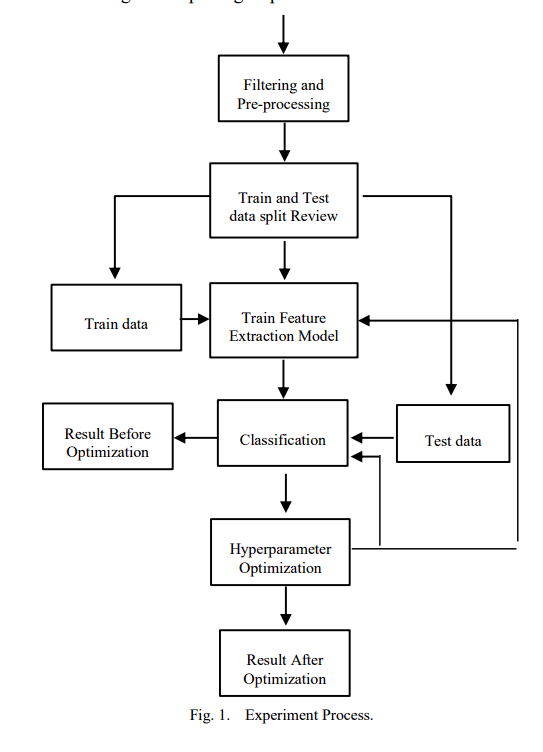
#### -> First train classifiers with vectorizers having standard parameters, then hypertune Vectorizors and train best classifier again with different different vectorizer settings
#### GloVe is not included, since its trained in C

In [24]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

# vectorizer_name is one of the following 'w2v_cbow' / 'w2v_skipg' / 'fasttext' / 'tfidf_vectors' / 'count_vectors'
# returns best parameter combination for vectorizer 'vectorizer_name' with given classifier
def hypertuneVectorizor(estimator, vectorizer_name):
    
    best_acc = 0
    best_model = {}
    parameters = ParameterGrid({})
    
    
    
    if vectorizer_name == 'tfidf_vectors' or vectorizer_name == 'count_vectors':
        
        parameters = ParameterGrid({
        'ngram_range': [(1,1), (1,2)], #[(1,1), (1,2), (2,2)]
        'max_features': [50000, 100000], #[None, 15000, 25000, 50000, 100000, 200000, 400000]
        'min_df': [2, 5]
        })
        
        X_train, X_test, y_train, y_test = train_test_split(train_data, train_target['label'], test_size=0.2, random_state=0)
        
    else:
        
        parameters = ParameterGrid({
        'min_count': [2, 5], #[2, 5, 8]
        'vector_size': [100], #[50, 100, 200, 300]
        'window': [5, 10] #[5, 10]
        })
        
        tokens = get_train_tokens(train_data)
        X_train, X_test, y_train, y_test = train_test_split(tokens, train_target['label'], test_size=0.2, random_state=0)
        del tokens

    
    for param_comb in parameters:
         
        if vectorizer_name == 'tfidf_vectors':
                
            emb_train = get_tfid_vectors(X_train, param_comb)
            emb_test = get_tfid_vectors(X_test, param_comb)
                
        elif vectorizer_name == 'count_vectors':
                
            emb_train = get_count_vectors(X_train,param_comb)
            emb_test = get_count_vectors(X_test,param_comb)
            
        elif vectorizer_name == 'w2v_cbow':
                
            emb_train = get_w2v_cbow_embeddings(X_train, param_comb)
            emb_test = get_w2v_cbow_embeddings(X_test, param_comb)
                
        elif vectorizer_name == 'w2v_skipg':
                
            emb_train = get_w2v_skipg_embeddings(X_train, param_comb)
            emb_test = get_w2v_skipg_embeddings(X_test, param_comb)
                
        elif vectorizer_name == 'fasttext':
                
            emb_train = get_fasttext_embeddings(X_train, param_comb)
            emb_test = get_fasttext_embeddings(X_test, param_comb)
                
                
        model.fit(emb_train.toarray(), y_train)
        predictions = model.predict(emb_test.toarray())
        
        acc = accuracy_score(y_test, predictions)
            
        if acc > best_acc:
            best_acc = acc
            best_model = {'vectorizer': vectorizer_name, 'parameters': param_comb, 'acc': best_acc}
                
    return best_model
    
  

In [25]:
#model, vectorizer_name, vectorizers = hyper_tune()

best_param_model = hypertuneVectorizor(model, vectorizer_name)

ValueError: X has 13192 features, but MultinomialNB is expecting 24665 features as input.

In [25]:
# search for an optimal value of K for KNN

# list of integers 1 to 30
# integers we want to try
k_range = range(1, 31)

# list of scores from k_range
k_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, get_tfid_vectors(train_data).toarray(), train_target['label'], cv=5, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())
print(k_scores)

[0.7278801843317972, 0.690983956306537, 0.74263099505035, 0.750021334698754, 0.7656724697047278, 0.7638504864311315, 0.7749061273254823, 0.7841355180064857, 0.7970344768731865, 0.7924261819423111, 0.7970302099334357, 0.7979604027991124, 0.8062638675541901, 0.7979689366786141, 0.7961256187062639, 0.8062596006144392, 0.8053379416282643, 0.8062553336746886, 0.8044120157023384, 0.8007083119986346, 0.806242532855436, 0.80531660692951, 0.808994708994709, 0.8044077487625876, 0.8071599249018604, 0.8080815838880355, 0.8053080730500085, 0.80531660692951, 0.8099249018603857, 0.8071556579621095]


Text(0, 0.5, 'Cross-Validated Accuracy')

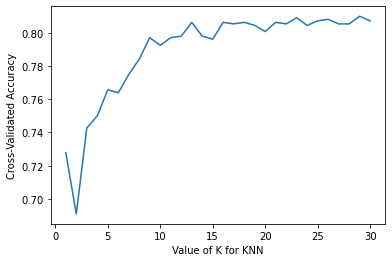

In [26]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [27]:
# search for an optimal value of K for KNN

# list of integers 1 to 30
# integers we want to try
k_range = range(1, 31)

# list of scores from k_range
k_scores_count = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, get_count_vectors(train_data).toarray(), train_target['label'], cv=5, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores_count.append(scores.mean())
print(k_scores_count)

[0.3911461000170678, 0.3699394094555385, 0.3164277180406213, 0.30350315753541557, 0.34958183990442054, 0.3910436934630483, 0.43535159583546684, 0.4233742959549412, 0.4455282471411504, 0.44738863287250386, 0.4501280081925243, 0.4483060249189282, 0.445536781020652, 0.4427718040621266, 0.4418672128349548, 0.43816350913125107, 0.45477043864140637, 0.44737583205325143, 0.45381037719747397, 0.4621181088923024, 0.45381464413722483, 0.4639656938044035, 0.4538231780167264, 0.4584400068271036, 0.4501450759515276, 0.44829322409967565, 0.45195852534562214, 0.44734169653524497, 0.4316649598907663, 0.4381293736132446]


Text(0, 0.5, 'Cross-Validated Accuracy')

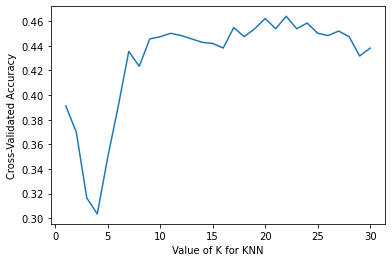

In [28]:
# plot the value of K on Count vectors for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores_count)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [29]:
# search for an optimal value of leaf size for KNN

# list of integers 1 to 30
# integers we want to try
leafsize_range = range(5, 150)

# list of scores from leafsize_range
leafsize_scores = []

# 1. we will loop through reasonable values of leaf size
for l in leafsize_range:
    # 2. run KNeighborsClassifier with l leaf sizes
    knn = KNeighborsClassifier(leaf_size=l)
    # 3. obtain cross_val_score for KNeighborsClassifier with l leaf sizes
    scores = cross_val_score(knn, get_tfid_vectors(train_data).toarray(), train_target['label'], cv=5, scoring='accuracy')
    # 4. append mean of scores for leaf sizes to leafsize_scores list
    leafsize_scores.append(scores.mean())
print(leafsize_scores)

[0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278, 0.7656724697047278,

Text(0, 0.5, 'Cross-Validated Accuracy')

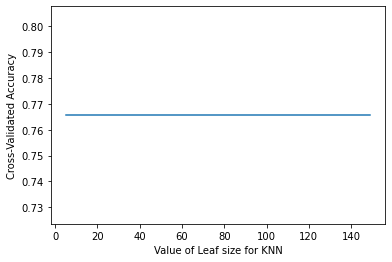

In [30]:
# plot the value of leafsize on TFIDF vectors for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(leafsize_range, leafsize_scores)
plt.xlabel('Value of Leaf size for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [32]:
# search for an optimal value of leaf size for KNN

# list of integers 1 to 30
# integers we want to try
leafsize_range = range(5, 150)

# list of scores from leafsize_range
leafsize_scores_count = []

# 1. we will loop through reasonable values of leaf size
for l in leafsize_range:
    # 2. run KNeighborsClassifier with l leaf sizes
    knn = KNeighborsClassifier(leaf_size=l)
    # 3. obtain cross_val_score for KNeighborsClassifier with l leaf sizes
    scores = cross_val_score(knn, get_count_vectors(train_data).toarray(), train_target['label'], cv=5, scoring='accuracy')
    # 4. append mean of scores for leaf sizes to leafsize_scores list
    leafsize_scores_count.append(scores.mean())
print(leafsize_scores_count)

[0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.34958183990442054, 0.3495818399

Text(0, 0.5, 'Cross-Validated Accuracy')

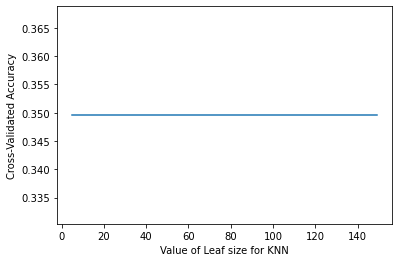

In [33]:
# plot the value of leafsize on Count vectors for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(leafsize_range, leafsize_scores_count)
plt.xlabel('Value of Leaf size for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [34]:
# search for an optimal value of n estimators for RFC
# list of integers 100 to 150
# integers we want to try
n_estimators_range = range(100, 151)

# list of scores from n_estimators_range
n_estimators_scores = []

# 1. we will loop through reasonable values of n_estimators_range
for n in n_estimators_range:
    # 2. run RandomForestClassifier with n estimators
    rfc = RandomForestClassifier(n_estimators=n)
    # 3. obtain cross_val_score for RandomForestClassifier with n estimators
    scores = cross_val_score(rfc, get_tfid_vectors(train_data).toarray(), train_target['label'], cv=5, scoring='accuracy')
    # 4. append mean of scores for n estimators to n_estimators_scores list
    n_estimators_scores.append(scores.mean())
print(n_estimators_scores)

[0.7628562894691926, 0.762852022529442, 0.7730073391363713, 0.7729945383171188, 0.7702380952380953, 0.7600913125106673, 0.7693377709506741, 0.7591867212834955, 0.7702636968766001, 0.7665642601126472, 0.7564217443249701, 0.760099846390169, 0.7628904249871993, 0.7665599931728965, 0.7721112817887011, 0.76194743130227, 0.7665642601126472, 0.7720814132104454, 0.7674987199180747, 0.7619602321215224, 0.7647081413210446, 0.7776327018262502, 0.7628818911076974, 0.7702167605393411, 0.7628648233486943, 0.7545656255333675, 0.7693249701314218, 0.7638035500938727, 0.7720984809694487, 0.7610513739545997, 0.7693207031916709, 0.7656298003072196, 0.7554915514592935, 0.7674603174603174, 0.7665727939921487, 0.7711768219832736, 0.7656383341867212, 0.7720984809694487, 0.766568527052398, 0.7739332650622972, 0.7711768219832736, 0.7711768219832736, 0.7693121693121693, 0.7554958183990441, 0.7610129714968424, 0.7711682881037719, 0.7582565284178189, 0.7600913125106674, 0.7739332650622973, 0.7656084656084656, 0.77

Text(0, 0.5, 'Cross-Validated Accuracy')

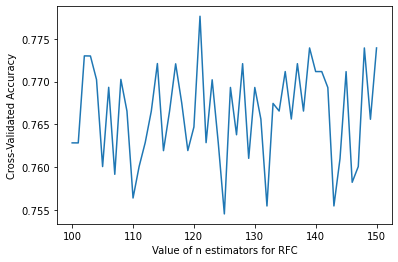

In [35]:
# plot the value of n estimators on TFIDF vectors for RFC (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(n_estimators_range,n_estimators_scores)
plt.xlabel('Value of n estimators for RFC')
plt.ylabel('Cross-Validated Accuracy')

In [42]:
# search for an optimal value of n estimators for RFC
# list of integers 100 to 150
# integers we want to try
n_estimators_range = range(100, 151)

# list of scores from n_estimators_range
n_estimators_scores_count = []

# 1. we will loop through reasonable values of n_estimators_range
for n in n_estimators_range:
    # 2. run RandomForestClassifier with n estimators
    rfc = RandomForestClassifier(n_estimators=n)
    # 3. obtain cross_val_score for RandomForestClassifier with n estimators
    scores = cross_val_score(rfc, get_count_vectors(train_data).toarray(), train_target['label'], cv=5, scoring='accuracy')
    # 4. append mean of scores for n estimators to n_estimators_scores list
    n_estimators_scores_count.append(scores.mean())
print(n_estimators_scores_count)

[0.7877752176139273, 0.7683819764464925, 0.7748719918074757, 0.767494452978324, 0.7674901860385731, 0.7591824543437447, 0.7748677248677248, 0.7711768219832736, 0.771189622802526, 0.7702551629970985, 0.7693292370711726, 0.7693463048301759, 0.776715309779826, 0.772115548728452, 0.766568527052398, 0.7619431643625193, 0.766568527052398, 0.7785586277521761, 0.7721070148489504, 0.7720942140296979, 0.7702636968766001, 0.7656596688854753, 0.7748719918074757, 0.7610257723160949, 0.765646868066223, 0.7684075780849975, 0.7794717528588496, 0.7702551629970985, 0.7638163509131249, 0.7739375320020481, 0.7840885816692268, 0.7776369687660011, 0.773037207714627, 0.7683990442054959, 0.7637992831541219, 0.7711853558627753, 0.7684075780849974, 0.7794802867383513, 0.7656255333674689, 0.773015873015873, 0.7776199010069978, 0.7803976787847755, 0.7813236047107015, 0.7730030721966206, 0.772115548728452, 0.7767025089605735, 0.7665642601126472, 0.7804190134835297, 0.7684033111452466, 0.7822452636968766, 0.7674859

Text(0, 0.5, 'Cross-Validated Accuracy')

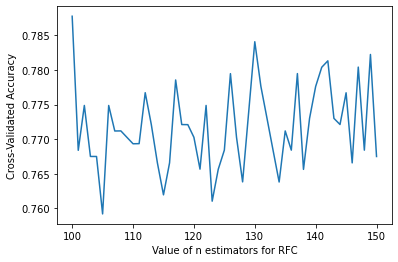

In [43]:
# plot the value of n estimators on Count vectors for RFC (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(n_estimators_range,n_estimators_scores_count)
plt.xlabel('Value of n estimators for RFC')
plt.ylabel('Cross-Validated Accuracy')

In [36]:
# search for an optimal value of max_features for RFC   'max_features': ['auto', 'sqrt']

# Values we want to try
max_features = ['auto', 'sqrt']

# list of scores from max_features_range
max_features_scores = []

# 1. we will loop through reasonable values of max_features
for m in max_features:
    # 2. run RandomForestClassifier with max_features
    rfc = RandomForestClassifier(max_features=m) 
    # 3. obtain cross_val_score for RandomForestClassifier with max_features
    scores = cross_val_score(rfc, get_tfid_vectors(train_data).toarray(), train_target['label'], cv=5, scoring='accuracy')
    # 4. append mean of scores for max_features to max_features_scores list
    max_features_scores.append(scores.mean())
print(max_features_scores)

[0.7610343061955965, 0.7628605564089435]


Text(0, 0.5, 'Cross-Validated Accuracy')

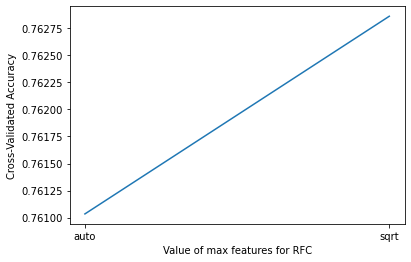

In [45]:
# plot the value of max features on TFIDF vectors for RFC (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(max_features,max_features_scores)
plt.xlabel('Value of max features for RFC')
plt.ylabel('Cross-Validated Accuracy')

In [52]:
# search for an optimal value of max_depth for RFC max_depth_range

# Values we want to try
max_depth_range_rfc = range(5,100)

# list of scores from max_depth_range
max_depth_scores_rfc = []

# 1. we will loop through reasonable values of max_depth_range
for m in max_depth_range:
    # 2. run RandomForestClassifier with max_depth_range
    rfc = RandomForestClassifier(max_depth=m) 
    # 3. obtain cross_val_score for RandomForestClassifier with max_depth
    scores = cross_val_score(rfc, get_tfid_vectors(train_data).toarray(), train_target['label'], cv=5, scoring='accuracy')
    # 4. append mean of scores for max_depth to max_depth_scores list
    max_depth_scores_rfc.append(scores.mean())
print(max_depth_scores_rfc)

[0.7204343744666326, 0.7342592592592593, 0.7287421061614611, 0.7416581327871651, 0.7517878477555897, 0.7360897764123571, 0.7305640894350571, 0.7287293053422086, 0.7388675541901348, 0.746279228537293, 0.7554744837002901, 0.7554616828810377, 0.7582479945383171, 0.7684075780849975, 0.7518006485748422, 0.7591909882232464, 0.7610087045570916, 0.7674859190988224, 0.7527223075610172, 0.7518006485748421, 0.7517963816350912, 0.7573434033111452, 0.7517878477555897, 0.760099846390169, 0.7702508960573478, 0.7573050008533879, 0.7665727939921487, 0.7720942140296978, 0.7674901860385731, 0.7591824543437447, 0.771168288103772, 0.771168288103772, 0.765625533367469, 0.7545698924731183, 0.7683947772657451, 0.7850017067759003, 0.7545485577743642, 0.7684075780849975, 0.7757893838539, 0.7656340672469705, 0.7739375320020482, 0.766547192353644, 0.7665599931728964, 0.7739375320020482, 0.7656255333674689, 0.7693292370711726, 0.7674816521590715, 0.7656255333674689, 0.7721070148489504, 0.7813193377709506, 0.774863

Text(0, 0.5, 'Cross-Validated Accuracy')

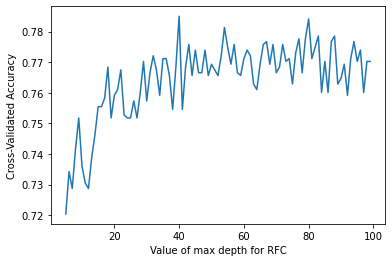

In [53]:
# plot the value of max depth on TFIDF vectors for RFC (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(max_depth_range_rfc, max_depth_scores_rfc)
plt.xlabel('Value of max depth for RFC')
plt.ylabel('Cross-Validated Accuracy')

In [48]:
# search for an optimal value of max_depth for DTC max_depth_range

# Values we want to try
max_depth_range = range(5,100)

# list of scores from max_depth_range
max_depth_scores_dtc = []

# 1. we will loop through reasonable values of max_depth_range
for m in max_depth_range:
    # 2. run DecisionTreeClassifier with max_depth_range
    dtc = DecisionTreeClassifier(max_depth=m) 
    # 3. obtain cross_val_score for DecisionTreeClassifier with max_depth
    scores = cross_val_score(dtc, get_tfid_vectors(train_data).toarray(), train_target['label'], cv=5, scoring='accuracy')
    # 4. append mean of scores for max_depth to max_depth_scores list
    max_depth_scores_dtc.append(scores.mean())
print(max_depth_scores_dtc)



[0.36533111452466294, 0.38377282812766683, 0.39393241167434717, 0.4234425669909541, 0.4262288786482335, 0.4391449052739375, 0.43452807646356034, 0.451126472094214, 0.4511350059737157, 0.45757808499743985, 0.4686465267110429, 0.4769414575866189, 0.4806323604710701, 0.49078341013824894, 0.49262246117084824, 0.4935483870967742, 0.507394606588155, 0.5203106332138591, 0.5230670762928827, 0.5295272230756103, 0.5285970302099334, 0.5359703020993344, 0.5350657108721625, 0.5230713432326335, 0.5332138590203106, 0.5378306878306879, 0.5461170848267622, 0.5488991295442908, 0.5470344768731865, 0.5590373783922171, 0.5479561358593616, 0.5581071855265404, 0.5488863287250383, 0.5525772316094897, 0.5507296466973887, 0.5599505034988905, 0.5663978494623655, 0.5544034818228367, 0.5599633043181431, 0.5553379416282642, 0.5663978494623655, 0.5627538829151733, 0.5664191841611197, 0.5701015531660693, 0.56826250213347, 0.5654847243556922, 0.5636371394435911, 0.5802398020139956, 0.5765574330090459, 0.57470558115719

Text(0, 0.5, 'Cross-Validated Accuracy')

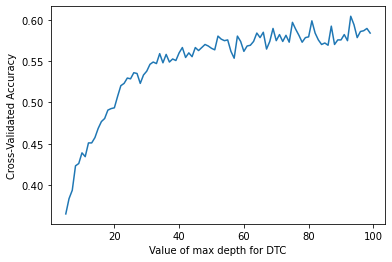

In [49]:
# plot the value of max depth on TFIDF vectors for DTC (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(max_depth_range,max_depth_scores_dtc)
plt.xlabel('Value of max depth for DTC')
plt.ylabel('Cross-Validated Accuracy')

In [54]:
# search for an optimal value of min_samples_split for DTC min_samples_split_range

# Values we want to try
min_samples_split_range_dtc = range(5,100)

# list of scores from min_samples_split_range_dtc
min_samples_split_scores_dtc  = []

# 1. we will loop through reasonable values of min_samples_split_range
for m in min_samples_split_range_dtc:
    # 2. run DecisionTreeClassifier with min_samples_split_range
    dtc = DecisionTreeClassifier(min_samples_split=m) 
    # 3. obtain cross_val_score for DecisionTreeClassifier with min_samples_split
    scores = cross_val_score(dtc, get_tfid_vectors(train_data).toarray(), train_target['label'], cv=5, scoring='accuracy')
    # 4. append mean of scores for min_samples_split to min_samples_split_scores_dtc list
    min_samples_split_scores_dtc.append(scores.mean())
print(min_samples_split_scores_dtc)
                

[0.5783794162826421, 0.5774918928144734, 0.583926437958696, 0.5719406041986688, 0.572857996245093, 0.5682497013142175, 0.5848054275473631, 0.5728707970643454, 0.5774705581157195, 0.5857654889912954, 0.5719406041986688, 0.5876173408431473, 0.5996074415429254, 0.6106502816180235, 0.5820831199863459, 0.5691542925413893, 0.585752688172043, 0.5866871479774705, 0.5875960061443932, 0.5922469704727769, 0.6097456903908516, 0.5922384365932754, 0.5857612220515447, 0.5912911759685954, 0.5922469704727769, 0.5802312681344939, 0.5922384365932752, 0.597747055811572, 0.5922256357740229, 0.588568868407578, 0.600520566649599, 0.5968424645844, 0.5959208055982249, 0.5903951186209251, 0.5756400409626217, 0.5839307048984469, 0.5959378733572283, 0.5784135518006486, 0.5848395630653695, 0.5903865847414235, 0.5682454343744666, 0.5784306195596518, 0.5719448711384195, 0.5913039767878477, 0.5719576719576719, 0.5765403652500426, 0.5765360983102918, 0.5913167776071002, 0.5839008363201912, 0.5848651647038744, 0.582083

Text(0, 0.5, 'Cross-Validated Accuracy')

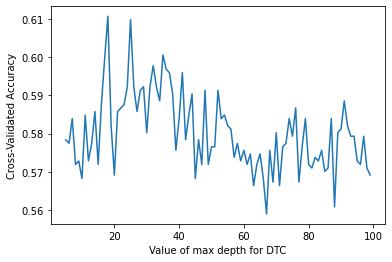

In [55]:
# plot the value of min samples split on TFIDF vectors for DTC (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(min_samples_split_range_dtc,min_samples_split_scores_dtc)
plt.xlabel('Value of min_samples_split for DTC')
plt.ylabel('Cross-Validated Accuracy')

In [57]:
# search for an optimal value of alpha for MNB alpha_range

# Values we want to try
alpha_range = (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)

# list of scores from alpha_range
alpha_scores = []

# 1. we will loop through reasonable values of alpha_range
for a in alpha_range :
    # 2. run MNB with alpha_range
    mnb = MultinomialNB(alpha=a) 
    # 3. obtain cross_val_score for MNB with alpha_range
    scores = cross_val_score(mnb, get_tfid_vectors(train_data).toarray(), train_target['label'], cv=5, scoring='accuracy')
    # 4. append mean of scores for alpha_range to alpha_scores list
    alpha_scores.append(scores.mean())
print(alpha_scores)
                

[0.8459165386584742, 0.8496245093019287, 0.8366914149172213, 0.8246927803379416, 0.818241167434716, 0.8136286055640894]


Text(0, 0.5, 'Cross-Validated Accuracy')

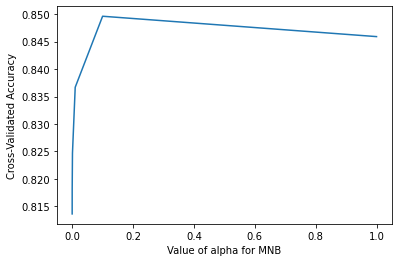

In [59]:
# plot the value of alpha on TFIDF vectors for MNB (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(alpha_range,alpha_scores)
plt.xlabel('Value of alpha for MNB')
plt.ylabel('Cross-Validated Accuracy')

In [60]:
# search for an optimal value of alpha for MLP hidden_layer_sizes

# Values we want to try
hidden_layer_sizes_range = range(50,300,10)

# list of scores from alpha_range
hidden_layer_sizes_scores = []

# 1. we will loop through reasonable values of hidden_layer_sizes_range
for h in hidden_layer_sizes_range :
    # 2. run MNB with alpha_range
    mlp = MLPClassifier(hidden_layer_sizes=h) 
    # 3. obtain cross_val_score for MLP with hidden_layer_sizes_range
    scores = cross_val_score(mlp, get_tfid_vectors(train_data).toarray(), train_target['label'], cv=5, scoring='accuracy')
    # 4. append mean of scores for hidden_layer_sizes_range to hidden_layer_sizes_scores list
    hidden_layer_sizes_scores.append(scores.mean())
print(hidden_layer_sizes_scores)


[0.8283922171018945, 0.8274833589349718, 0.8237967229902715, 0.8228665301245947, 0.8228707970643455, 0.8293224099675713, 0.8293181430278205, 0.829326676907322, 0.837621607782898, 0.8274748250554701, 0.8311657279399215, 0.8256400409626217, 0.8320831199863458, 0.8367084826762244, 0.8274748250554703, 0.8293309438470728, 0.8274918928144734, 0.8256272401433691, 0.8320916538658475, 0.8330090459122717, 0.8293352107868237, 0.8311742618194231, 0.8265574330090459, 0.828405017921147, 0.8311657279399215]


Text(0, 0.5, 'Cross-Validated Accuracy')

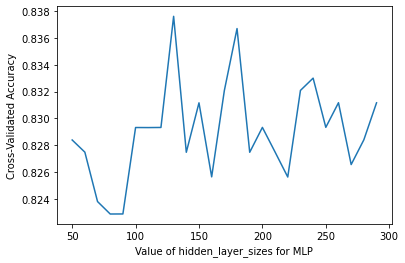

In [61]:
# plot the value of  on TFIDF vectors for MLP (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(hidden_layer_sizes_range,hidden_layer_sizes_scores)
plt.xlabel('Value of hidden_layer_sizes for MLP')
plt.ylabel('Cross-Validated Accuracy')
